In [88]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
g = torch.Generator().manual_seed(2147483647)
# n_embd = 20 # Param of C
# n_hidden = 200 # Columns in W
BLOCK_SIZE = 8 # original was 3
VOCAB_SIZE = 27 # same as vocab size
EMB_DIM = 10 # the dimensionality of the character embedding vectors С - batch size?
N_HIDDEN = 200 # the number of neurons in the hidden layer of the MLP - columns of W
BATCH_SIZE = 32
g = torch.Generator().manual_seed(2147483647) # for reproducibility

In [47]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
s2i = {s:i+1 for i,s in enumerate(chars) }
s2i['.'] = 0 # special for Start or End
i2s = {i:s for s,i in s2i.items()}

In [48]:
def build_ds(words):
     # how many chars do we take to predict the next one
    xs, ys = [], [] # xs are 3 leading chars, ys is the 4th char
    # eg for emma -> first xs is 000 and first ys is e
    # second xs is ..e ys is m
    # etc
    for w in words:
        
        context = [0]*BLOCK_SIZE # 0 marks beginning/no letter from front
        for ch in w+'.': # eg emma.
            ix = s2i[ch]
            (xs.append(context), ys.append(ix))
            # print(''.join(i2s[i] for i in context), ' ---> ', ch)
            context = context[1:] + [ix] # note this context doesn't become part of the training set, because it is like ma. -> and always leads to .
     # X is say 32 x 3       
    return torch.tensor(xs), torch.tensor(ys) 

# shuffle and define training/dev/eval sets
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_ds(words[:n1])
Xdev, Ydev = build_ds(words[n1:n2])
Xte, Yte = build_ds(words[n2:])

In [49]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    # .item() converts single element array to scalar
    print(''.join(i2s[ix.item()] for ix in x), '-->', i2s[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [92]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    # print("weight", self.weight.shape)
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    """
    x is 32x30 (after embedding and flattening). On first iteration, x is just random numbers
    """
    # print("Linear")
    # print("x", x.shape)
    self.out = x @ self.weight # eg 32x30 @ 30x100 -> 32x100 Matrix multiply 
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim) # mean , always of size N_HIDDEN, ie across BATCH_SIZE (and WaveNet) channels 
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    """
    x is 32x100 (output of Linear layer)
    wavenet x is 32x4x200
    """
    
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        d = 0
      elif x.ndim == 3:
        d = (0,1)

      xmean = x.mean(d, keepdim=True) # batch mean - across axis 0 and 1, shape is 1xBATCH_SIZE
      xvar = x.var(d, keepdim=True) # batch variance - across axis 0 and 1
    else: # if we are not training then we use the running mean and variance that we have been tracking
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        # Exponential Moving Average 2, alpha = momentum
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
  
class Embedding:

    def __init__(self, n_emb, emb_dim):
        self.weight = torch.randn((n_emb, emb_dim), generator=g) 

    def __call__(self, x):
        # x is 32x3 (batch of 32 examples, each is 3 chars represented as integers)
        # we want to return 32x(3*20) (embedding each char to 20 dims and flattening)
        self.out = self.weight[x] # index into the embedding matrix - this gives us a 32x3x20 tensor
        return self.out

    def parameters(self):
        return [self.weight]
    
class FlattenConsecutive:
    
    def __init__(self, n):
       self.n = n # how many consecutive tokens to flatten together

    def __call__(self, x):
        # x is 32x3x10
        # self.out = x.view(x.shape[0], -1) # flatten the last two dimensions - this gives us a 32x30 tensor

        # OR x is 32x8x10
        # For WaveNet we want out to be BATCH_SIZE, 4, 20
        # then 4 pairs (20 represents a pair ie 2x10)
        b, t, c = x.shape # currently , B is 32, T is 3/8, C is 10
        self.out = x.view(b, t // self.n, self.n * c) # reshape to 32x1x80

        if self.out.shape[1] == 1:
           self.out = self.out.squeeze(1) # if we have only one token, then we don't need to flatten, we can just squeeze the middle dimension

        return self.out
    
    def parameters(self):
        return []
    

class Sequential:
    def __init__(self, layers):
        self.layers = layers
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    


In [93]:
WAVENET = 2

model = Sequential( [
  Embedding(VOCAB_SIZE, EMB_DIM), # C is 27x10, and Xb is 32x3, out: 32x3x10

  # Note WaveNet - above we squashed all the information into that single layer of 100 in a single step.
  # Instead, take 2 chars to predict next
  # then take two of those predicted to predict next (so now 4 chars used) etc etc etc


  FlattenConsecutive(WAVENET), # out: 32x30 / 32x20 because we flatten the last two dimensions of z
  Linear(EMB_DIM * WAVENET, N_HIDDEN, bias=False), BatchNorm1d(N_HIDDEN), Tanh(), # in: 32x80 out: 32x100 

  FlattenConsecutive(WAVENET), 
  Linear(N_HIDDEN * WAVENET, N_HIDDEN, bias=False), BatchNorm1d(N_HIDDEN), Tanh(), # in: 32x80 out: 32x100 

  FlattenConsecutive(WAVENET),
  Linear(N_HIDDEN * WAVENET, N_HIDDEN, bias=False), BatchNorm1d(N_HIDDEN), Tanh(), # in: 32x80 out: 32x100 

  Linear(N_HIDDEN, VOCAB_SIZE, bias=False)
  
  
])

layers = model.layers

with torch.no_grad():
  # last layer: make less confident
  # layers[-1].gamma *= 0.1
  layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3 # this is to fight tanh's squashing . Otherwise weights would ALL GO TO 0. Set to 1 if only Linear layers

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

170870


In [ ]:
# Appendix A

C.shape # rand 27x10
display(Xtr.shape) # N x 3
display(Xb.shape) # 32 x 3
Xb.shape # 32x3 because ix is rand 0-182625, of shape [batchsize=32]
z = C[Xb]
z.shape # 32x3x10
zz = z.view(z.shape[0], -1)
zz.shape # 32x30 because we flatten the last two dimensions of z


dim = 3  # Let's use 3 dimensions for the example
eps = 1e-5

# 1. Initialize running mean to zeros
running_mean = torch.zeros(dim) 

# 2. Fake input data (3 samples, 3 features)
# Notice feature 0 has large numbers, feature 2 has small numbers
x = torch.tensor([
    [10.0, 1.0, 0.1],
    [20.0, 1.5, 0.2],
    [30.0, 2.0, 0.3]
])

# 3. Calculate current batch mean and variance
xmean = x.mean(0) # [20, 1.5, 0.2]
print(xmean)
xvar = x.var(0, unbiased=False)

# 4. Normalize (The xhat formula)
xhat = (x - xmean) 

print(xhat)

xhat2 = xhat/ torch.sqrt(xvar + eps)

print(xhat2)

tensor([20.0000,  1.5000,  0.2000])
tensor([[-10.0000,  -0.5000,  -0.1000],
        [  0.0000,   0.0000,   0.0000],
        [ 10.0000,   0.5000,   0.1000]])
tensor([[-1.2247, -1.2247, -1.2238],
        [ 0.0000,  0.0000,  0.0000],
        [ 1.2247,  1.2247,  1.2238]])


In [ ]:
# Appendix B

import torch

# C: 5 items, each is a vector of size 2
C = torch.tensor([
    [10, 11], # Index 0
    [20, 21], # Index 1
    [30, 31], # Index 2
    [40, 41], # Index 3
    [50, 51]  # Index 4
]) # Shape: torch.Size([5, 2])

# Xb: A 2x2 grid of indices we want to look up
Xb = torch.tensor([
    [0, 4],
    [1, 2]
]) # Shape: torch.Size([2, 2])

z = C[Xb] 

print(z.shape) 
# Output: torch.Size([2, 2, 2])

print(z)
# Result:
# tensor([[[10, 11], [50, 51]],
#         [[20, 21], [30, 31]]])
l = z.view(z.shape[0], -1) # concatenate the vectors
print(l)  


torch.Size([2, 2, 2])
tensor([[[10, 11],
         [50, 51]],

        [[20, 21],
         [30, 31]]])
tensor([[10, 11, 50, 51],
        [20, 21, 30, 31]])


In [ ]:
# Appendix C
display ( (torch.randn(4,80) @ torch.randn(80,200) + torch.randn(200) ).shape ) # this is how the Linear layer does its matrix multiplication
a = torch.randn(2, 3, 4)
b = torch.randn(4,1)
print(a,"\n",b)
display ( ( a@ b  ) ) # this is how the Linear layer does its matrix multiplication

(1,2), (3,4)

# we want 4x4x20 (batch size 8, is two groups of 4 and 20 is )

torch.Size([4, 200])

tensor([[[ 2.0491,  2.0311,  1.0106, -0.9904],
         [-0.5694, -1.2252, -1.2599,  1.1708],
         [ 0.2149, -0.5142,  0.6690,  0.2096]],

        [[ 1.1299, -0.1293,  0.5090, -0.2256],
         [-0.7054,  0.6246, -0.1519, -0.3006],
         [-0.0240, -0.3534,  0.9315, -1.9323]]]) 
 tensor([[0.0225],
        [0.5896],
        [0.3895],
        [0.5173]])


tensor([[[ 1.1249],
         [-0.6202],
         [ 0.0707]],

        [[ 0.0307],
         [ 0.1377],
         [-0.8457]]])

((1, 2), (3, 4))

In [94]:
# same optimization as last time
max_steps = 100_000
lossi = [] # track loss over time
ud = [] # track update to parameter ratios over time
L = 10_000
P = 10_000
reduce_lr_after = 70_000 # step learning rate decay

for layer in model.layers:
    layer.training = True

for i in range(max_steps):
  
  # minibatch constructa
  # pick batch_size random Xs and Ys from the training set
  ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,), generator=g)
  # display("ix", ix.shape)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  logits = model(Xb) # forward pass - logits are the output of the last layer, before softmax
    
  # Combines SOFTMAX and CROSS ENTROPY loss in one function. 
  # Applies softmax to the output of the last layer to get probabilities, 
  # then computes the cross-entropy loss with respect to the true labels Yb.
  # see Oxford NN coursework
  loss = F.cross_entropy(logits, Yb)

  # print("loss", loss)
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph - this is for plotting

  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < reduce_lr_after else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats


  if i % P == 0: # print every once in a while
    _al = lossi[-L:]
    avg_loss = sum(_al) / len(_al) if len(_al) > L else loss
    print(f'{i:7d}/{max_steps:7d}: {avg_loss:.4f}')

  lossi.append(loss.log10().item())
  
  # with torch.no_grad():
  #   ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  # if i >= 1000:
  #   break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 100000: 3.2878
  10000/ 100000: 1.9817
  20000/ 100000: 2.2585
  30000/ 100000: 2.0734
  40000/ 100000: 2.1152
  50000/ 100000: 2.2426
  60000/ 100000: 1.8551
  70000/ 100000: 1.9272
  80000/ 100000: 1.9588
  90000/ 100000: 2.0020


In [91]:
for l in model.layers:
    n = l.__class__.__name__
    print(n, ':', tuple(l.out.shape))
    if n in ('Tanh', 'Embedding'):
        print("\n")

Embedding : (32, 8, 10)


FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 200)
BatchNorm1d : (32, 4, 200)
Tanh : (32, 4, 200)


FlattenConsecutive : (32, 2, 400)
Linear : (32, 2, 200)
BatchNorm1d : (32, 2, 200)
Tanh : (32, 2, 200)


FlattenConsecutive : (32, 400)
Linear : (32, 200)
BatchNorm1d : (32, 200)
Tanh : (32, 200)


Linear : (32, 27)


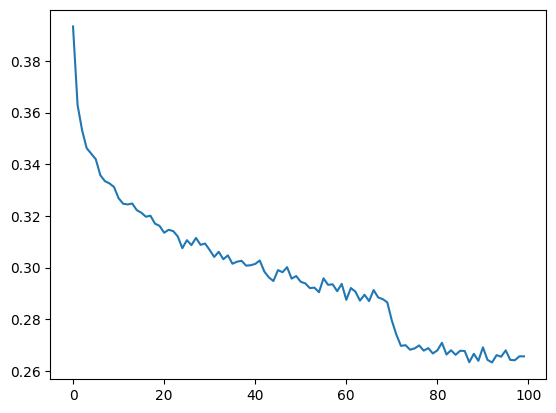

In [95]:
# take average over 1000 steps to smooth it out, and plot
## the drop is after reduce_lr_after, there we continue locally
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1)) # 200

In [62]:
for layer in model.layers:
    layer.training = False # set all layers to evaluation mode (this will make BatchNorm use running stats instead of batch stats)

@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item():.4f}')

split_loss('train')
split_loss('dev')

train loss: 2.0088
dev loss: 2.0740


In [63]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * BLOCK_SIZE # initial context is all start tokens
    while True:
        logits = model(torch.tensor([context])) # get the logits for the current context
        probs = F.softmax(logits, dim=1) # convert to probabilities
        ix = torch.multinomial(probs, num_samples=1).item() # sample from the distribution
        out.append(ix)
        context = context[1:] + [ix] # shift the context and add the new character
        if ix == 0: # if we sampled the end token, stop
            break
    print(''.join(i2s[i] for i in out))

adam.
jenix.
sanuky.
lenet.
lequal.
kemont.
lauly.
alei.
mairronq.
jakyim.
chaniel.
jnoelyn.
laylani.
rheemies.
jerea.
marvi.
modaliah.
cailyn.
xiannah.
gohnary.


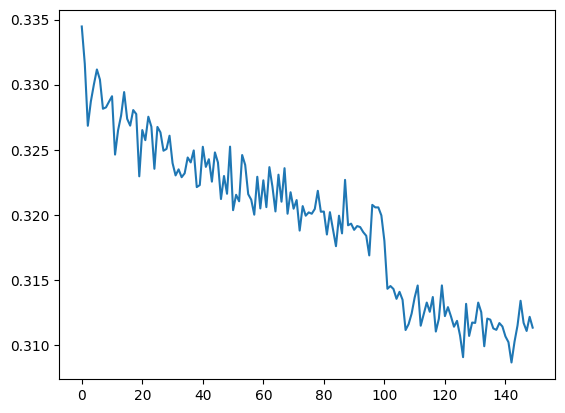

layer 2 (      Tanh): mean -0.02, std 0.67, saturated: 9.56%
layer 5 (      Tanh): mean -0.02, std 0.71, saturated: 11.75%
layer 8 (      Tanh): mean +0.00, std 0.72, saturated: 11.38%
layer 11 (      Tanh): mean +0.02, std 0.73, saturated: 10.09%
layer 14 (      Tanh): mean -0.02, std 0.74, saturated: 10.59%


Text(0.5, 1.0, 'activation distribution')

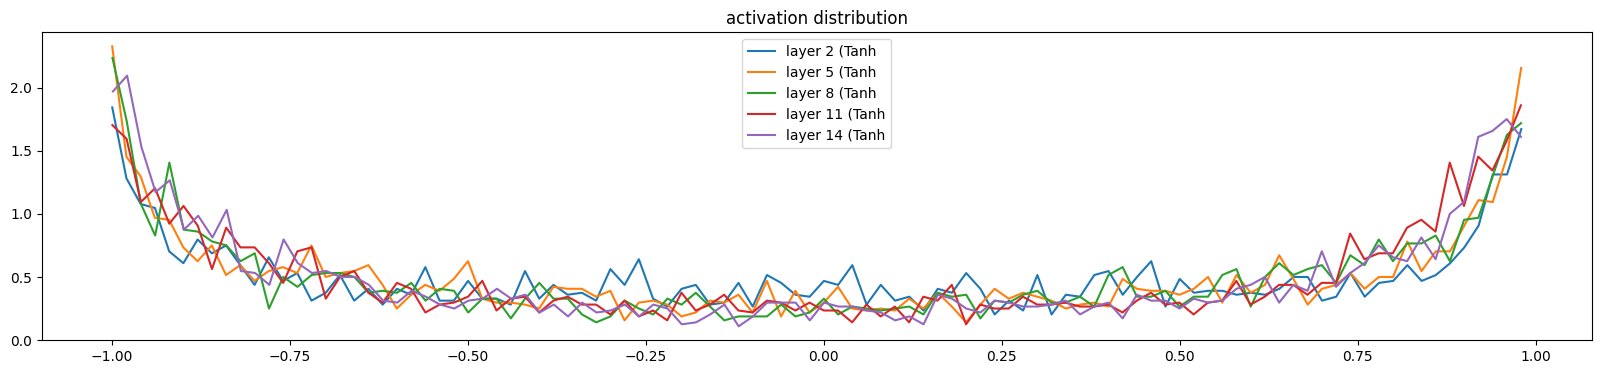

In [ ]:
# visualize histograms -  you want to be STABLE, and have some std - so a line is good
# if std --> 0, that means your weights are identical (ie same number in the tensor)
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

2

layer 2 (      Tanh): mean -0.000000, std 3.233143e-03
layer 5 (      Tanh): mean -0.000000, std 3.064847e-03
layer 8 (      Tanh): mean +0.000000, std 3.083902e-03
layer 11 (      Tanh): mean -0.000000, std 3.039404e-03
layer 14 (      Tanh): mean -0.000000, std 3.212891e-03


Text(0.5, 1.0, 'gradient distribution')

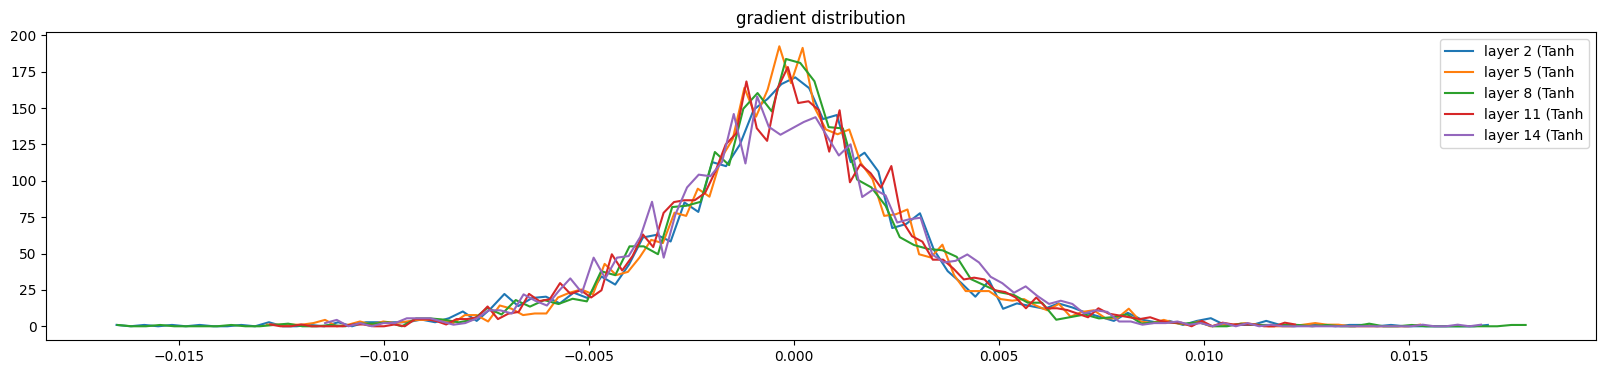

In [34]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.274368e-02 | grad:data ratio 1.248951e-02
weight  (30, 100) | mean +0.000029 | std 7.786609e-03 | grad:data ratio 2.271389e-02
weight (100, 100) | mean +0.000048 | std 5.163592e-03 | grad:data ratio 2.620369e-02
weight (100, 100) | mean +0.000013 | std 4.842958e-03 | grad:data ratio 2.489667e-02
weight (100, 100) | mean +0.000050 | std 4.856288e-03 | grad:data ratio 2.532366e-02
weight (100, 100) | mean +0.000017 | std 4.537649e-03 | grad:data ratio 2.400530e-02
weight  (100, 27) | mean -0.000032 | std 7.902810e-03 | grad:data ratio 3.355981e-02


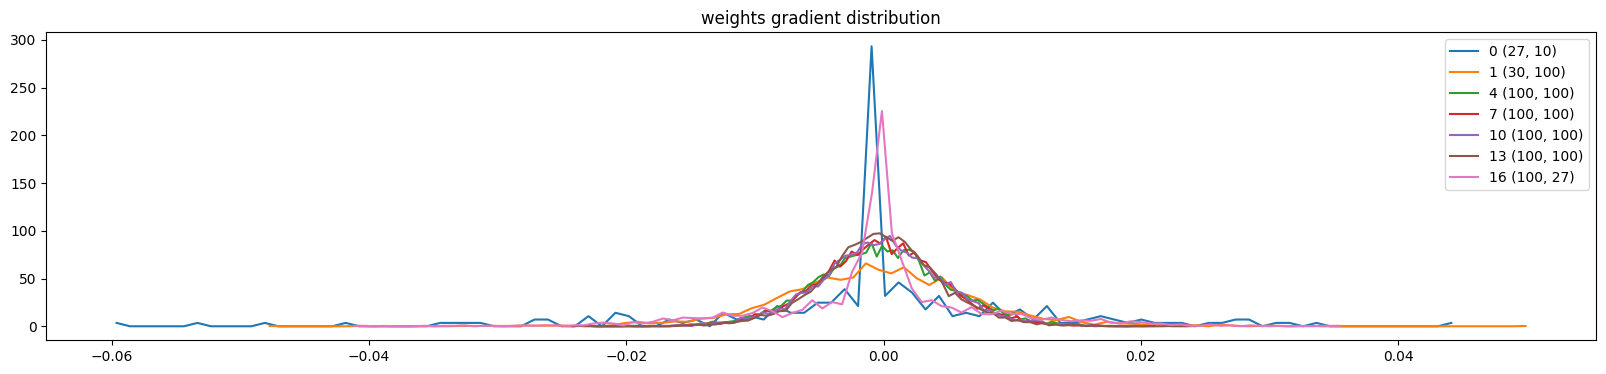

In [35]:
# if Grad is alot more volatile than weights - its a problem. Why?
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2: #this is only weights, no gammas, biases etc
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

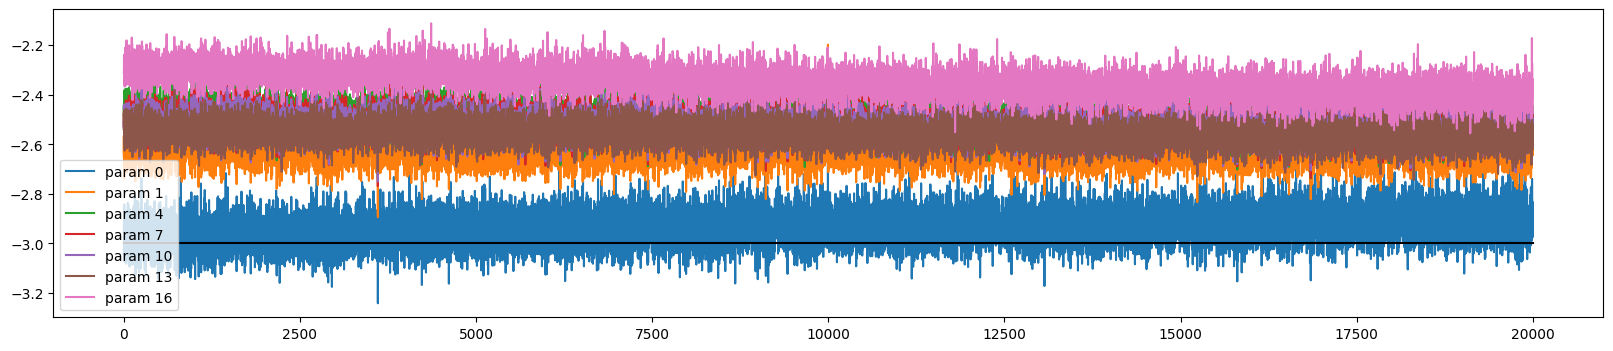

In [46]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2: #just weights
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [47]:
torch.cuda.is_available()

False